In [1]:
import numpy as np
import pykitti
import os
import math
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import copy
import sys
sys.path.append("/Users/lzherdeva/Docs/Open3D/build/lib")
import py3d

In [2]:
basedir = '/Users/lzherdeva/Docs/Diploma/'

def load_data(date, drive, frame):
    dataset = pykitti.raw(basedir, date, drive)
    velo_dataset = list(dataset.velo)
    velo_data = velo_dataset[frame]
    
    print('\nDrive: ' + str(dataset.drive))

    return velo_data

In [3]:
date = '2011_09_26'
drive = '0005'
velo_data = load_data(date, drive, 11)[:, [0,1,2]]


Drive: 2011_09_26_drive_0005_sync


In [4]:
velo_data

array([[22.811,  0.067,  0.98 ],
       [23.149,  0.141,  0.992],
       [23.226,  0.215,  0.995],
       ...,
       [ 5.724, -1.856, -2.69 ],
       [ 5.721, -1.835, -2.686],
       [ 5.721, -1.825, -2.684]], dtype=float32)

In [5]:
velo_data = velo_data[np.where((velo_data[:, 0] > -20) & (velo_data[:, 0] < 20) 
                               & (velo_data[:, 1] > -20) & (velo_data[:, 1] < 20) & (velo_data[:, 2] < 2))]

### Show input frame

In [6]:
pcd1 = py3d.PointCloud()
pcd1.points = py3d.Vector3dVector(velo_data)
py3d.draw_geometries([pcd1])

In [7]:
source_down = py3d.voxel_down_sample(pcd1, 0.3) # create a uniformly downsampled point cloud from an input point cloud
points = np.asarray(source_down.points)
velo_data = points

### Divide points into segments

In [8]:
def dotproduct(v1, v2):
    return sum((a*b) for a, b in zip(v1, v2))

def length(v):
    return math.sqrt(dotproduct(v, v))

def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def comp_angle(v1, v2):
    sign = dotproduct(v1, v2)
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    if sign > 0:
        if v1[1] < 0:
            return 360 - np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))
        else:
            return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))
    else:
        if v1[1] < 0:
            return 360 - np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))
        else:
            return np.degrees(np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0)))
            

In [9]:
ref_vector = [1, 0]
step = 0
scanlines = [[] for _ in range(360*2)]
for i in range(len(velo_data)):
    angle = comp_angle(velo_data[:, [0, 1]][i], ref_vector)
    index = 0
    for step in np.arange(0.5, 360+0.5, 0.5):
        if angle < step and angle >= step-0.5:
            try:
                scanlines[index].append(velo_data[i])
            except:
                print(index, step)
        index+=1

$$ \frac{x - x_1}{x_2 - x_1} = \frac{y - y_1}{y_2 - y_1} = \frac{z - z_1}{z_2 - z_1}$$


### Sorted by z-coordinate

In [11]:
import operator
from convert import convert_to_variables

In [12]:
scans = [[] for _ in range(len(scanlines))]
for num in range(0, len(scanlines), 1):
    zs = {}
    for i, p in enumerate(scanlines[num]):
        if p[1] == 0:
            z = p[1] / p[0]
        else:
            y = np.sqrt(1. / (1. + (p[0] / p[1]) ** 2))
            z = y * (p[2] / p[1])
        zs[z] = i
    sorted_zs  = np.array(sorted(zs.items(), key=operator.itemgetter(0)))
    if len(sorted_zs) == 0:
        scans[num] = []
    else:
        true_scanline = []
        for index in sorted_zs[:, [1]]:
            true_scanline.append(scanlines[num][int(index)])
        true_scanline = np.array(true_scanline)
        scans[num] = true_scanline

### Create clusters

In [38]:
def get_clusters(cur_scan):
    clusters = [[] for _ in range(len(cur_scan))]
    base_pho = cur_scan[0][0]**2 + cur_scan[0][1]**2 + cur_scan[0][2]**2
    clusters[0].append(cur_scan[0])
    ind = 0
    for i in range(1, len(cur_scan)):
        pho = cur_scan[i][0]**2 + cur_scan[i][1]**2 + cur_scan[i][2]**2
        if abs(base_pho - pho) >=2:
            ind += 1
            clusters[ind].append(np.array(cur_scan[i]))
            base_pho = pho
        else:
            clusters[ind].append(np.array(cur_scan[i])) 
    return clusters


In [15]:
clusters = [[] for _ in range(len(scans))]
for i in range(len(scans)):
    if len(scans[i]) == 0:
        clusters[i] = []
    else:
        clusters[i] = get_clusters(scans[i])
    

### Get median == new scanlines

In [39]:
def get_new_scanline(clusters):
    medians = []
    for i in range(len(clusters)):
        if clusters[i] != []:
            medians.append(np.median(clusters[i], axis=0))
    return medians

In [18]:
new_scanlines = [[] for _ in range(len(clusters))]
for i in range(len(clusters)):
    new_scanlines[i] = get_new_scanline(clusters[i])

### Get variables

In [19]:
sVs = [[] for _ in range(len(new_scanlines))]
for i in range(len(new_scanlines)):
    if len(new_scanlines[i]) == 1:
        sVs[i] = [0]
    elif len(new_scanlines[i]) == 0:
        sVs[i] = [0]
    else:
        try:
            sVs[i] = convert_to_variables(np.array(new_scanlines[i]))
        except:
            print(len(new_scanlines[i]))

In [40]:
def plot(sVs):
    plt.plot(range(len(sVs)), sVs)
    plt.show()

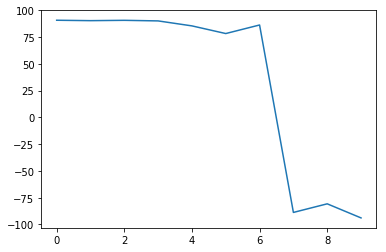

In [45]:
plt.plot(range(len(sVs[10])), sVs[10])

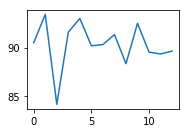

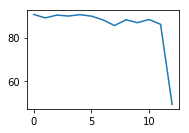

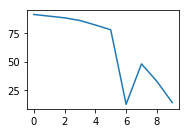

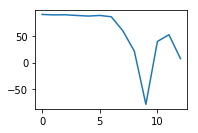

In [46]:
plt.figure(1)
for i in range(1, 5):
    plt.subplot(220+i)
    plot(sVs[i])
    

### CUSUM

In [47]:
from Statistics import Cusum

In [48]:
def calculate_cusum_for_scanline(sVs):
    stat_trajectory = []
    mean_0 = 0.
    mean_8 = 90.
    std = 1.

    cusum = Cusum(mean_0, mean_8, std, 20.)
    for x_k in sVs:
        cusum.update(x_k)
        stat_trajectory.append(cusum._alarm)
    return stat_trajectory

In [49]:
trajectories_cusum = [[] for _ in range(len(sVs))]
for i in range(len(sVs)):
    if len(sVs[i]) == 1:
        trajectories_cusum[i] = 1
    else:
        trajectories_cusum[i] = calculate_cusum_for_scanline(sVs[i])

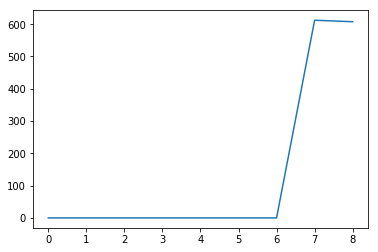

In [50]:
plt.plot(trajectories_cusum[220])

### Статистика Ширяева-Робертса

In [51]:
from Statistics import ShiryaevRoberts

In [52]:
def calculate_sr_for_scanline(sVs):
    stat_trajectory = []
    mean_0 = 90.
    mean_8 = 0.
    std = 1.


    sr = ShiryaevRoberts(mean_0, mean_8, 20., max_stat=1e6)
    for x_k in sVs:
        sr.update(x_k)
        stat_trajectory.append(sr._alarm)
    return stat_trajectory

In [53]:
trajectories_sr = [[] for _ in range(len(sVs))]
for i in range(len(sVs)):
    if len(sVs[i]) == 1:
        trajectories_sr[i] = 1
    else:
        trajectories_sr[i] = calculate_sr_for_scanline(sVs[i])

/Users/lzherdeva/Docs/Diploma/Statistics.py:67: RuntimeWarning: overflow encountered in exp
  likelihood = np.exp(mean_diff * (value - mean_diff / 2.))


In [55]:
trajectories_sr[0]

[50000.0,
 50000.0,
 50000.0,
 50000.0,
 50000.0,
 50000.0,
 50000.0,
 50000.0,
 50000.0,
 50000.0,
 50000.0,
 50000.0,
 0.0]

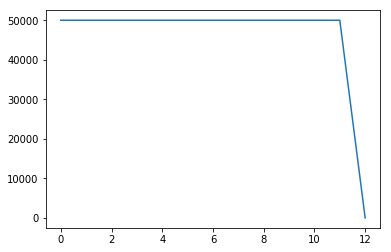

In [58]:
plt.plot(trajectories_sr[0])

### Visualization

### CUSUM

In [65]:
changed_indx = [[] for _ in range(len(trajectories_cusum))]
zero_indx = [[] for _ in range(len(trajectories_cusum))]
for i in range(len(trajectories_cusum)):
    changed_indx[i] = np.nonzero(trajectories_cusum[i])[0]
    zero_indx[i] = np.where(np.asarray(trajectories_cusum[i]) == 0)[0]

In [66]:
horizontal = []
vertical = []
for ind in range(len(new_scanlines)):
    if len(changed_indx[ind]) is not 0:
        arr = np.array(new_scanlines[ind])[changed_indx[ind]]
        vertical.append(arr)
        
for ind in range(len(new_scanlines)):
    if len(zero_indx[ind]) is not 0:
        arr = np.array(new_scanlines[ind])[zero_indx[ind]]
        horizontal.append(arr)
 

In [67]:
ver_cloud = []
for i in range(len(vertical)):
    for p in vertical[i]:
        ver_cloud.append(p)
        
        
pcd1 = py3d.PointCloud()
pcd1.points = py3d.Vector3dVector(ver_cloud)

#py3d.draw_geometries([pcd1])

In [68]:
hor_cloud = []
for i in range(len(horizontal)):
    for p in horizontal[i]:
        hor_cloud.append(p)
        
        
pcd2 = py3d.PointCloud()
pcd2.points = py3d.Vector3dVector(hor_cloud)

#py3d.draw_geometries([pcd2])

In [69]:
def draw_registration_result(vertical, horizontal):
    vertical_temp = copy.deepcopy(vertical)
    horizontal_temp = copy.deepcopy(horizontal)
    vertical_temp.paint_uniform_color([1, 0, 0]) # red
    horizontal_temp.paint_uniform_color([0, 0, 1]) # blue
    py3d.draw_geometries([vertical_temp, horizontal_temp])

In [70]:
draw_registration_result(pcd1, pcd2)

### SR

In [71]:
changed_indx = [[] for _ in range(len(trajectories_sr))]
non_changed_indx = [[] for _ in range(len(trajectories_sr))]
for i in range(len(trajectories_sr)):
    non_changed_indx[i] = np.where(np.asarray(trajectories_sr[i]) == 50000.0)[0]
    changed_indx[i] = np.where(np.asarray(trajectories_sr[i]) != 50000.0)[0]

In [73]:
horizontal = []
vertical = []
for ind in range(len(new_scanlines)):
    if len(changed_indx[ind]) is not 0:
        arr = np.array(new_scanlines[ind])[changed_indx[ind]]
        vertical.append(arr)
        
for ind in range(len(new_scanlines)):
    if len(non_changed_indx[ind]) is not 0:
        arr = np.array(new_scanlines[ind])[non_changed_indx[ind]]
        horizontal.append(arr)
 

In [74]:
ver_cloud = []
for i in range(len(vertical)):
    for p in vertical[i]:
        ver_cloud.append(p)
        
        
pcd1 = py3d.PointCloud()
pcd1.points = py3d.Vector3dVector(ver_cloud)

#py3d.draw_geometries([pcd1])

In [75]:
hor_cloud = []
for i in range(len(horizontal)):
    for p in horizontal[i]:
        hor_cloud.append(p)
        
        
pcd2 = py3d.PointCloud()
pcd2.points = py3d.Vector3dVector(hor_cloud)

#py3d.draw_geometries([pcd2])

In [76]:
draw_registration_result(pcd1, pcd2)

### Искусственные данные

In [167]:
points = np.zeros((50, 3))

In [168]:
for i in range(20):
    points[i][0] = 3
    points[i][1] = -i*0.2
    points[i][2] = 0 

In [169]:
for i in range(30):
    points[i+20][0] = 3
    points[i+20][1] = 0
    points[i+20][2] = i*0.2

In [170]:
points[:, 0] = points[:,0] + np.random.normal(0,0.02,50)
points[:, 1] = points[:,1] + np.random.normal(0,0.02,50)
points[:, 2] = points[:,2] + np.random.normal(0,0.02,50)

(-5, 5)

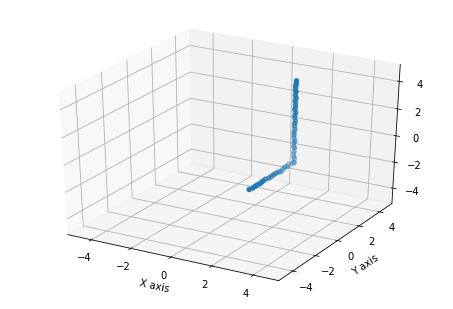

In [171]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
axes = [0,1,2]
axes_str = ['X', 'Y', 'Z']
axes_limits = [
    [-5, 5], # X axis range
    [-5, 5], # Y axis range
    [-5, 5]   # Z axis range
]
ax.scatter(*np.transpose(points[:, axes]))
ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
ax.set_xlim3d(*axes_limits[axes[0]])
ax.set_ylim3d(*axes_limits[axes[1]])
ax.set_zlim3d(*axes_limits[axes[2]])

In [172]:
def find_sV(points):
    Ds = np.zeros((points.shape[0] - 1, points.shape[1]))
    Vs = np.zeros((points.shape[0] - 1))

    for i in range(len(points) - 1):
        Ds[i] = points[i+1] - points[i]
    z = [0,0,1]
    for i in range(len(points) -1):
        Vs[i] = angle(Ds[i], z)
    s = np.zeros(Ds.shape[0] - 1)
    sV = np.zeros(Ds.shape[0] - 1)
    for i in range(0, Ds.shape[0] - 1):
        s[i] = np.sign(np.dot(Ds[i+1], Ds[i]))
        sV[i] = s[i] * Vs[i]
    return sV
  
    

In [113]:
sVs = []
for i in range(len(cloud)):
    sVs.append(find_sV(cloud[i]))
    

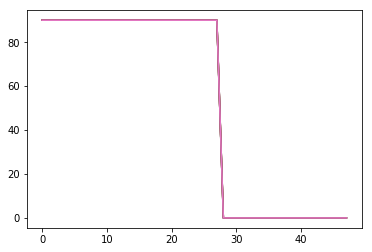

In [114]:
for i in range(len(cloud)):
    plt.plot(range(len(sVs[2])), sVs[2])

### Point-cloud

In [72]:
cloud = np.zeros((7, 50, 3))

In [85]:
for i in range(50):
    cloud[0][i][0] = i*0.2
    cloud[0][i][1] = 0
    cloud[0][i][2] = i* 0.001

for i in range(50):
    cloud[1][i][0] = i*0.2
    cloud[1][i][1] = i*0.2
    cloud[1][i][2] = i* 0.001

for i in range(30):
    cloud[2][i][0] = -i*0.2
    cloud[2][i][1] = i*0.3
    cloud[2][i][2] = 0
    
for i in range(1, 21):
    cloud[2][i+29][0] = -29*0.2
    cloud[2][i+29][1] = 29*0.3
    cloud[2][i+29][2] = i*0.2
    
for i in range(30):
    cloud[3][i][0] = -i*0.2
    cloud[3][i][1] = i*0.4
    cloud[3][i][2] = 0
    
for i in range(1, 21):
    cloud[3][i+29][0] = -29*0.2
    cloud[3][i+29][1] = 29*0.4
    cloud[3][i+29][2] = i*0.2
    

for i in range(50):
    cloud[4][i][0] = i*0.2
    cloud[4][i][1] = i*0.5
    cloud[4][i][2] = i* 0.002
    

for i in range(50):
    cloud[5][i][0] = -i*0.2
    cloud[5][i][1] = -i*0.5
    cloud[5][i][2] = 0  
    
for i in range(50):
    cloud[6][i][0] = i*0.2
    cloud[6][i][1] = -i*0.3
    cloud[6][i][2] = 0  

Text(0.5,0,'Y axis')

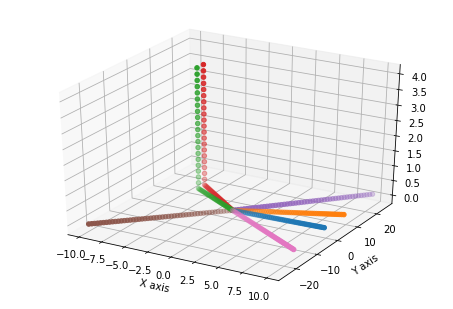

In [86]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
axes = [0,1,2]
axes_str = ['X', 'Y', 'Z']
axes_limits = [
    [-1, 10], # X axis range
    [-1, 10], # Y axis range
    [-1, 5]   # Z axis range
]
ax.scatter(*np.transpose(cloud[0][:, axes]))
ax.scatter(*np.transpose(cloud[1][:, axes]))
ax.scatter(*np.transpose(cloud[2][:, axes]))
ax.scatter(*np.transpose(cloud[3][:, axes]))
ax.scatter(*np.transpose(cloud[4][:, axes]))
ax.scatter(*np.transpose(cloud[5][:, axes]))
ax.scatter(*np.transpose(cloud[6][:, axes]))

ax.set_xlabel('{} axis'.format(axes_str[axes[0]]))
ax.set_ylabel('{} axis'.format(axes_str[axes[1]]))
#ax.set_xlim3d(*axes_limits[axes[0]])
#ax.set_ylim3d(*axes_limits[axes[1]])
#ax.set_zlim3d(*axes_limits[axes[2]])